# Loading libraries and functions

In [ ]:
# Install required libraries
# %%capture
!pip install neurodsp
!pip install emd
!pip install tslearn
!pip install dtaidistance
!pip install sails
!pip install umap-learn

In [1]:
# Load required libraries
import numpy as np
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
import emd
import pandas as pd
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
from tslearn.clustering import TimeSeriesKMeans, KShape
from tslearn.metrics import dtw
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
import copy
import sails
import umap.umap_ as umap

sns.set(style='white', context='notebook')

In [2]:
# Function to load LFP data from .mat files
# The input includes both the LFP datafile and the sleep-scoring states file
# The LFP data should be cleaned using the matlab artifact cleaning
def load_mat_data(path_to_data, file_name, states_file):
    data = loadmat(path_to_data + file_name)
    data = data['PFClfpCleaned'].flatten()

    states = loadmat(path_to_data + states_file)
    states = states['states'].flatten()
    return data, states

In [3]:
# extract all nrem epochs from the sleep-scoring states file
def get_first_NREM_epoch(arr, start):
  start_index = None
  for i in range(start, len(arr)):
    if arr[i] == 3:
      if start_index is None:
        start_index = i
    elif arr[i] != 3 and start_index is not None:
      return (start_index, i - 1, i)

  return (start_index, len(arr) - 1, len(arr)) if start_index is not None else None

def get_all_NREM_epochs(arr):
  nrem_epochs = []
  next_start = 0
  while next_start < len(arr)-1:
    indices = get_first_NREM_epoch(arr, next_start)
    if indices == None:
      break
    start, end, next_start = indices
    if end-start <= 30:
      continue
    nrem_epochs.append([start, end])
  return nrem_epochs

In [4]:
# Concatenating all the NREM epochs and filtering on the Delta band (0.1-4 Hz)
def get_nrem_filtered(pfc_data, nrem_epochs, fs):
  nrem_data = []
  for start, end in nrem_epochs:
    pfc_data_part = pfc_data[start*fs:end*fs]
    nrem_data.extend(pfc_data_part)
  nrem_data = np.array(nrem_data)
  nrem_filtered_data = filter_signal(nrem_data, fs, 'bandpass', (0.1, 4), n_cycles=3, filter_type='iir', butterworth_order=6, remove_edges=False)
  return nrem_filtered_data, nrem_data

In [5]:
# Get cycle filtered on conditions. Make a copy so the original is not affected.
def get_cycles_with_conditions(cycles, conditions):
    C = copy.deepcopy(cycles)
    C.pick_cycle_subset(conditions)
    return C

In [6]:
# Functions to calculate metrics
def peak_before_trough(arr):
  trough_val = np.min(arr)
  trough_pos = np.argmin(arr)
  for i in range(trough_pos - 1, 0, -1):
    if arr[i] > arr[i - 1] and arr[i] > arr[i + 1] and arr[i]>=0:
      return arr[i]
  return -1

def peak_before_trough_pos(arr):
  trough_val = np.min(arr)
  trough_pos = np.argmin(arr)
  for i in range(trough_pos - 1, 0, -1):
    if arr[i] > arr[i - 1] and arr[i] > arr[i + 1] and arr[i]>=0:
      return i
  return -1

def peak_to_trough_duration(arr):
  trough_val = np.min(arr)
  trough_pos = np.argmin(arr)
  for i in range(trough_pos - 20, 0, -1):
    if arr[i] > arr[i - 1] and arr[i] > arr[i + 1] and arr[i]>=0:
      return trough_pos-i
  return -1

def num_inflection_points(arr):
  sign_changes = np.diff(np.sign(np.diff(arr, 2)))
  num_inflection_points = np.sum(sign_changes != 0)
  return num_inflection_points

def compute_range(x):
    return x.max() - x.min()

def asc2desc(x):
    pt = emd.cycles.cf_peak_sample(x, interp=True)
    tt = emd.cycles.cf_trough_sample(x, interp=True)
    if (pt is None) or (tt is None):
        return np.nan
    asc = pt + (len(x) - tt)
    desc = tt - pt
    return asc / len(x)

def peak2trough(x):
    des = emd.cycles.cf_descending_zero_sample(x, interp=True)
    if des is None:
        return np.nan
    return des / len(x)

# Compute metrics for each cycle -
#     Maximum Amplitude
#     Cycle Duration
#     Trough Position and values
#     Peak (just before the trough) Position and Values
#     Peak Position and Values
#     Peak-to-Trough Duration
#     Peak to trough ratio ( P / P+T )
#     Ascending to Descending ratio ( A / A+D )
def get_cycles_with_metrics(cycles, data, IA, IF, conditions=None):
  C = copy.deepcopy(cycles)

  C.compute_cycle_metric('duration_samples', data, func=len)
  C.compute_cycle_metric('peak2trough', data, func=peak2trough)
  C.compute_cycle_metric('asc2desc', data, func=asc2desc)
  C.compute_cycle_metric('max_amp', IA, func=np.max)
  C.compute_cycle_metric('trough_values', data, func=np.min)
  C.compute_cycle_metric('peak_values', data, func=np.max)
  C.compute_cycle_metric('mean_if', IF, func=np.mean)
  C.compute_cycle_metric('max_if', IF, func=np.max)
  C.compute_cycle_metric('range_if', IF, func=compute_range)

  C.compute_cycle_metric('trough_position', data, func=np.argmin)
  C.compute_cycle_metric('peak_position', data, func=np.argmax)

  # C.compute_cycle_metric('peak_before_trough_val', nrem_filtered_data, func=peak_before_trough)
  # C.compute_cycle_metric('peak_before_trough_pos', nrem_filtered_data, func=peak_before_trough_pos)
  # C.compute_cycle_metric('avg_amp', IA, func=np.mean)
  # C.compute_cycle_metric('trough_position', nrem_filtered_data, func=np.argmin)
  # C.compute_cycle_metric('peak_position', nrem_filtered_data, func=np.argmax)
  # C.compute_cycle_metric('peak_to_trough_duration', nrem_filtered_data, func=peak_to_trough_duration)
  # C.compute_cycle_metric('num_inflection_points', nrem_filtered_data, func=num_inflection_points)
  # C.compute_cycle_metric('start_sample', np.arange(len(C.cycle_vect)), emd.cycles.cf_start_value)
  # C.compute_cycle_metric('stop_sample', imf, emd.cycles.cf_end_value)
  # C.compute_cycle_metric('peak_sample', imf, emd.cycles.cf_peak_sample)
  # C.compute_cycle_metric('desc_sample', imf, emd.cycles.cf_descending_zero_sample)
  # C.compute_cycle_metric('trough_sample', imf, emd.cycles.cf_trough_sample)
  return C

# Load data

In [7]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [8]:
# Loading sleep scoring data from MAT files stored in Google Drive.
# path_to_data = '/content/drive/My Drive/Donders Internship/2018-07-26_14-20-46_Post-Trial5/'
# data_file = 'PFClfpCleaned.mat'
# states_file = '2018-07-26_14-20-46_Post-Trial5-states.mat'

path_to_data = "./2018-07-26_14-20-46_Post-Trial5/"
data_file = 'PFClfpCleaned.mat'
states_file = '2018-07-26_14-20-46_Post-Trial5-states.mat'
pfc_data, sleep_scoring = load_mat_data(path_to_data, data_file, states_file)

nrem_epochs = np.array(get_all_NREM_epochs(sleep_scoring))

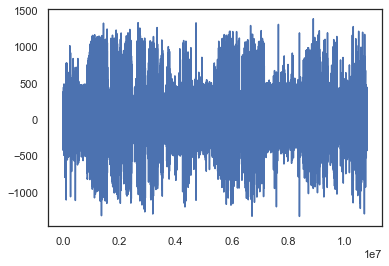

In [9]:
plt.plot(pfc_data);

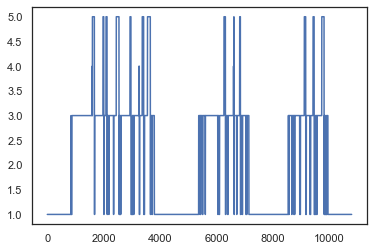

In [10]:
plt.plot(sleep_scoring);

In [11]:
# Samping frequency
len(pfc_data)/len(sleep_scoring)

1000.0773076566985

# Get All Cycles

In [12]:
# Set sampling frequency
fs = 1000

In [13]:
# Get filtered NREM LFP data
nrem_filtered_data, nrem_data = get_nrem_filtered(pfc_data, nrem_epochs, fs=fs)

C:\Users\nikhi\AppData\Roaming\Python\Python39\site-packages\neurodsp\filt\utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))


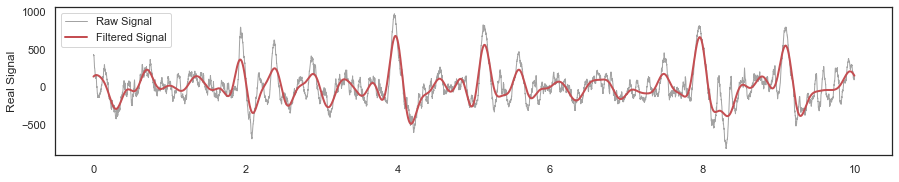

In [14]:
# Plot NREM filtered data (10 sec window)

start = fs*200 # Start position for signal
length = 10

t = np.arange(fs*length) / fs
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.plot(t,nrem_data[start:start+fs*length], 'k', label='Raw Signal', alpha=0.4, lw=1)
plt.plot(t,nrem_filtered_data[start:start+fs*length], 'r', label='Filtered Signal', lw=2)
plt.ylabel('Real Signal')
plt.legend()

In [15]:
# Get cycles using IP
IP, IF, IA = emd.spectra.frequency_transform(nrem_filtered_data, 1000, 'hilbert')

C = emd.cycles.Cycles(IP)

 Checking Cycles inputs - trimming singleton from input 'IP'


In [16]:
cycles = get_cycles_with_metrics(C, nrem_filtered_data, IA, IF)

In [17]:
# Define thresholds to filter food cycles and subset them
metrics = cycles.get_metric_dataframe()
peak_thresh = np.percentile(metrics['peak_values'], 85)
trough_thresh = np.percentile(metrics['trough_values'], 40)
delta_peak_thresh = np.percentile(metrics['peak_values'], 40)

lo_freq_duration = fs/0.1
hi_freq_duration = fs/4

In [18]:
# Apply conditions to get good cycles
conditions = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              # f'peak_values>={peak_thresh}',
              f'trough_values<={trough_thresh}']

all_cycles = get_cycles_with_conditions(cycles, conditions)

In [19]:
all_metrics = all_cycles.get_metric_dataframe(subset=True)

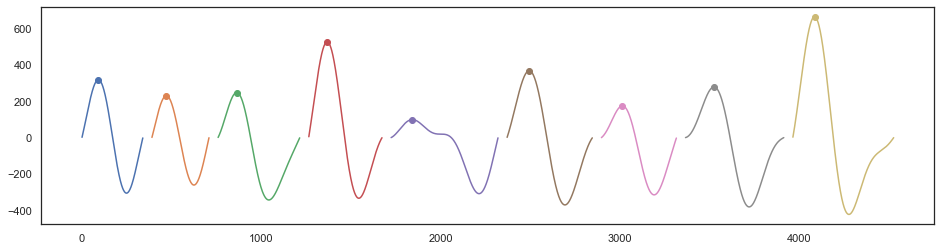

In [20]:
# Plot some exmaples of good cycles
cycles_to_plot = all_metrics['index'][11:20]
plt.figure(figsize=(16,4))
start = 0
for ii in cycles_to_plot:
  inds = cycles.get_inds_of_cycle(ii)
  cycle = nrem_filtered_data[inds]
  row = all_metrics[all_metrics['index'] == ii]
  xinds = np.arange(len(inds)) + start
  plt.plot(xinds, cycle)
  plt.scatter(row['peak_position']+start, row['peak_values'])

  start += len(inds)+50

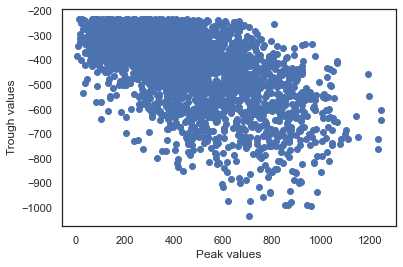

In [21]:
# Plot peak vs trough values

# fig = px.density_contour(metrics, x="peak_values", y="trough_values", marginal_x="histogram", marginal_y="histogram")
# fig.show()

plt.scatter(all_metrics['peak_values'], all_metrics['trough_values'])
plt.xlabel('Peak values')
plt.ylabel('Trough values');

# Get SO and delta cycles

In [22]:
conditions = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values>={peak_thresh}',
              f'trough_values<={trough_thresh}',
              ]
so_cycles = get_cycles_with_conditions(cycles, conditions)

In [23]:
conditions = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values<{peak_thresh}',
              f'trough_values<={trough_thresh}',
              ]
delta_cycles = get_cycles_with_conditions(cycles, conditions)

In [24]:
conditions = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values<{peak_thresh}',
              f'trough_values<={trough_thresh}',
              f'peak_values>{delta_peak_thresh}',
              ]
big_delta_cycles = get_cycles_with_conditions(delta_cycles, conditions)

In [25]:
conditions = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values<{peak_thresh}',
              f'trough_values<={trough_thresh}',
              f'peak_values<={delta_peak_thresh}',
              ]
small_delta_cycles = get_cycles_with_conditions(delta_cycles, conditions)

In [26]:
metrics_so = so_cycles.get_metric_dataframe(subset=True)
metrics_delta = delta_cycles.get_metric_dataframe(subset=True)

(0.0, 600.0)

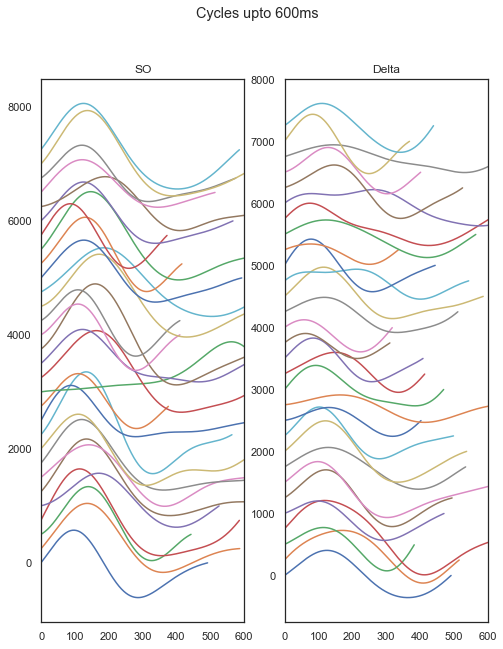

In [27]:
plt.figure(figsize=(8,10))
plt.suptitle("Cycles upto 600ms")

plt.subplot(1, 2, 1)
plt.title('SO')
start = 0
cycles_to_plot_so = np.random.choice(metrics_so['index'], 30)
for i in cycles_to_plot_so:
  inds = cycles.get_inds_of_cycle(i)
  cycle = nrem_filtered_data[inds]

  plt.plot(cycle+start)
  start += 250
plt.xlim((0,600))

plt.subplot(1, 2, 2)
plt.title('Delta')
# plt.yticks([])
start = 0
cycles_to_plot_delta = np.random.choice(metrics_delta['index'], 30)
for i in cycles_to_plot_delta:
  inds = cycles.get_inds_of_cycle(i)
  cycle = nrem_filtered_data[inds]

  plt.plot(cycle+start)
  start += 250
plt.xlim((0,600))

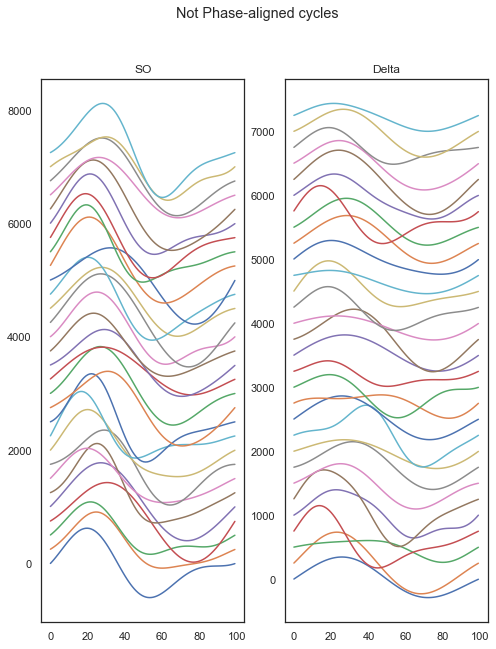

In [28]:
plt.figure(figsize=(8,10))
plt.suptitle("Not Phase-aligned cycles")

plt.subplot(1, 2, 1)
plt.title('SO')
# plt.yticks([])
start = 0
cycles_to_plot_so = np.random.choice(metrics_so['index'], 30)
for i in cycles_to_plot_so:
  inds = cycles.get_inds_of_cycle(i)
  cycle = nrem_filtered_data[inds]

  new_length = 100
  new_indices = np.linspace(0, len(cycle) - 1, new_length)

  interpolator = interp1d(np.arange(len(cycle)), cycle, kind='linear')
  downsampled_series = interpolator(new_indices)

  plt.plot(downsampled_series+start)
  # plt.plot(so_waveforms[:,i]+start)
  start += 250

plt.subplot(1, 2, 2)
plt.title('Delta')
# plt.yticks([])
start = 0
cycles_to_plot_delta = np.random.choice(metrics_delta['index'], 30)
for i in cycles_to_plot_delta:
  inds = cycles.get_inds_of_cycle(i)
  cycle = nrem_filtered_data[inds]

  new_length = 100
  new_indices = np.linspace(0, len(cycle) - 1, new_length)

  interpolator = interp1d(np.arange(len(cycle)), cycle, kind='linear')
  downsampled_series = interpolator(new_indices)

  plt.plot(downsampled_series+start)
  start += 250

# Phase-aligned cycles

In [29]:
all_waveforms, _ = emd.cycles.phase_align(IP, nrem_filtered_data,
                                                            cycles=all_cycles.iterate(through='subset'), npoints=100)
all_waveforms.shape

 Checking phase_align inputs - trimming singleton from input 'ip'


(100, 2795)

# Phase-aligned SO and Delta cycles

In [30]:
so_waveforms, _ = emd.cycles.phase_align(IP, nrem_filtered_data,
                                                            cycles=so_cycles.iterate(through='subset'), npoints=100)
delta_waveforms, _ = emd.cycles.phase_align(IP, nrem_filtered_data,
                                                            cycles=delta_cycles.iterate(through='subset'), npoints=100)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'


In [31]:
big_delta_waveforms, _ = emd.cycles.phase_align(IP, nrem_filtered_data,
                                                            cycles=big_delta_cycles.iterate(through='subset'), npoints=100)
small_delta_waveforms, _ = emd.cycles.phase_align(IP, nrem_filtered_data,
                                                            cycles=small_delta_cycles.iterate(through='subset'), npoints=100)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'


(-1000.0, 7000.0)

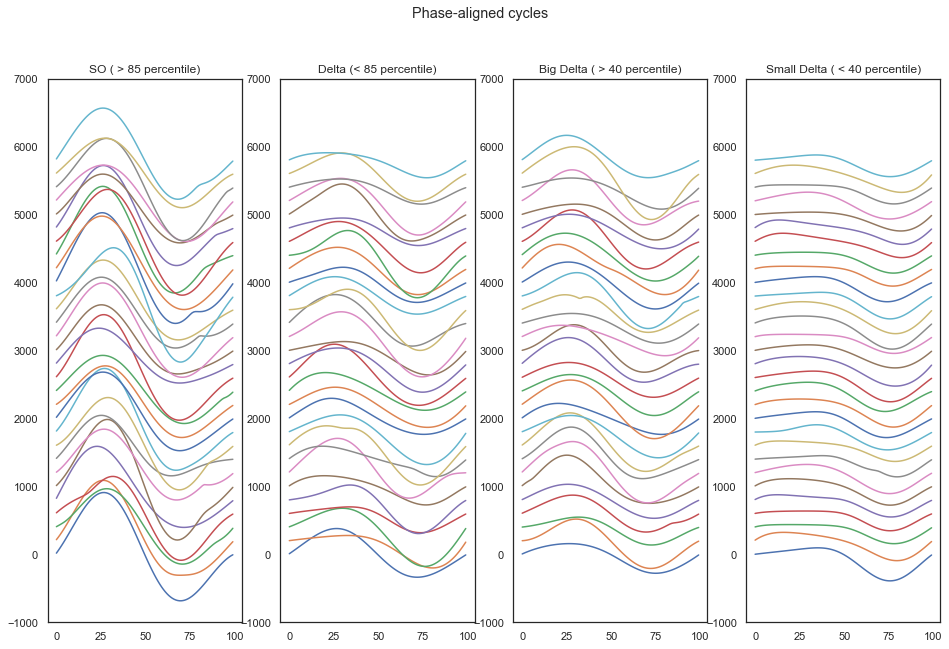

In [32]:
plt.figure(figsize=(16,10), facecolor='white')
plt.suptitle("Phase-aligned cycles")
plt.subplot(1, 4, 1)
plt.title('SO ( > 85 percentile)')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, so_waveforms.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(so_waveforms[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

plt.subplot(1, 4, 2)
plt.title('Delta (< 85 percentile)')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, delta_waveforms.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(delta_waveforms[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

plt.subplot(1, 4, 3)
plt.title('Big Delta ( > 40 percentile)')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, big_delta_waveforms.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(big_delta_waveforms[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

plt.subplot(1, 4, 4)
plt.title('Small Delta ( < 40 percentile)')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, small_delta_waveforms.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(small_delta_waveforms[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

# Analysis of IP and IF

(-5.0, 5.0)

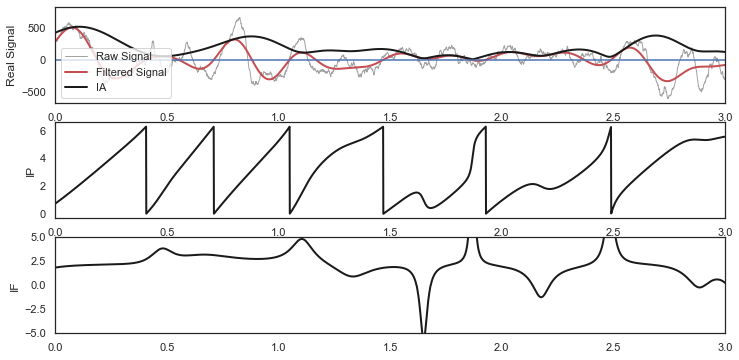

In [33]:
# Plot IA, IP, IF for a particular cycle (n sec window)

start = fs*50 # Start position for signal
length = 8

t = np.arange(fs*length) / fs
plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.plot(t,nrem_data[start:start+fs*length], 'k', label='Raw Signal', alpha=0.4, lw=1)
plt.plot(t,nrem_filtered_data[start:start+fs*length], 'r', label='Filtered Signal', lw=2)
plt.plot(t,IA[start:start+fs*length], 'k', label='IA', lw=2)
plt.ylabel('Real Signal')
plt.axhline(0)
plt.xlim((0, 3))
plt.legend();

plt.subplot(3,1,2)
plt.plot(t,IP[start:start+fs*length], 'k', label='IP', lw=2)
plt.ylabel('IP')
plt.xlim((0, 3))

plt.subplot(3,1,3)
plt.plot(t,IF[start:start+fs*length], 'k', label='IP', lw=2)
plt.ylabel('IF')
plt.xlim((0, 3))
plt.ylim((-5, 5))

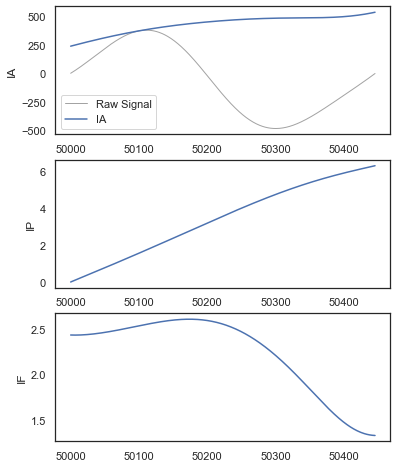

In [34]:
# Plot IA, IP, IF for a particular cycle

cycle_to_plot = 600

inds = cycles.get_inds_of_cycle(all_metrics['index'][cycle_to_plot])

plt.figure(figsize=(6,8))
plt.subplot(3,1,1)
cycle = IA[inds]
plt.plot(np.arange(len(inds)) + start,nrem_filtered_data[inds], 'k', label='Raw Signal', alpha=0.4, lw=1);
plt.plot(np.arange(len(inds)) + start, cycle, label='IA');
plt.legend()
plt.ylabel('IA')

plt.subplot(3,1,2)
cycle = IP[inds]
plt.plot(np.arange(len(inds)) + start, cycle);
plt.ylabel('IP')

plt.subplot(3,1,3)
cycle = IF[inds]
plt.plot(np.arange(len(inds)) + start, cycle);
plt.ylabel('IF');

In [35]:
pa, phasex = emd.cycles.phase_align(IP, IF, all_cycles.iterate(through='subset'))

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'


In [36]:
phase_aligned_ifs = pa.T

pca_pa_waveforms = PCA(n_components=5)
pca_pa_waveforms.fit(phase_aligned_ifs)
phase_aligned_components = pd.DataFrame(pca_pa_waveforms.transform(phase_aligned_ifs))
phase_aligned_components.columns = [f'PC-{i}' for i in range(1,6)]

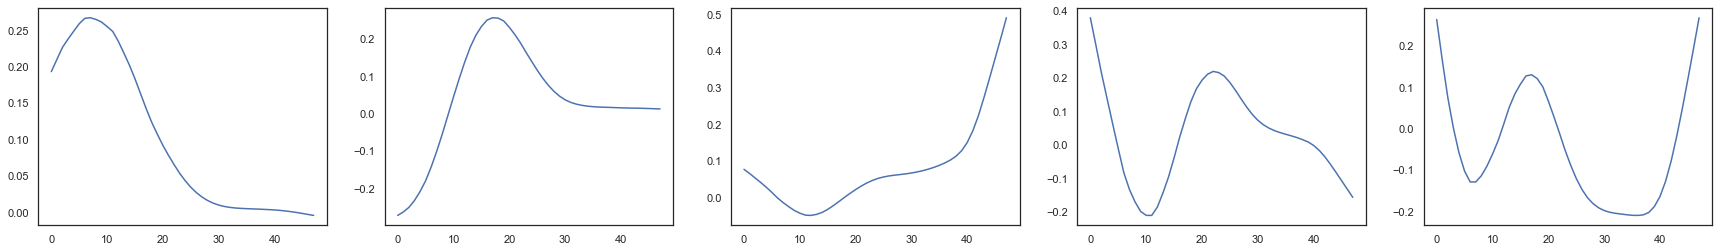

In [37]:
plt.figure(figsize=(30, 4))

for i in range(5):
    plt.subplot(1, len(pca_pa_waveforms.components_), i+1)
    pc = pca_pa_waveforms.components_[i]
    plt.plot(pc, label='PC')

In [38]:
def projection(pca, projection_score=0):
    pc_proj = np.zeros((pca_pa_waveforms.mean_.shape[0], 5))
    pc_proj.shape
    for ii in range(5):
        sc = np.zeros(5)
        sc[ii] = projection_score
        pc_proj[:, ii] = pca_pa_waveforms.inverse_transform(sc)
    return pc_proj

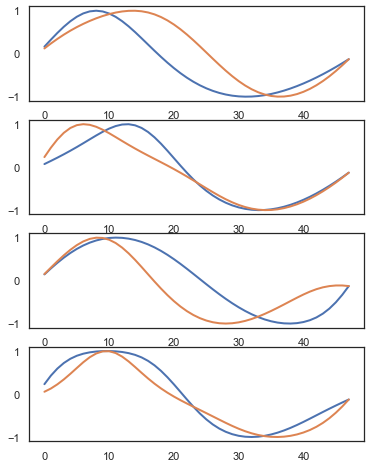

In [39]:
pc_proj = np.zeros((48, 2, 5))
val = 5  # PC-score to project
for ii in range(5):
    sc = np.zeros((2, 5))
    sc[0, ii] = val
    sc[1, ii] = -val
    pc_proj[:, :, ii] = pca_pa_waveforms.inverse_transform(sc).T

plt.figure(figsize=(6,8))
plt.subplot(4,1,1)
sr = pc_proj[:, 0, 0].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 0, 0], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2)

sr = pc_proj[:, 1, 0].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 1, 0], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2)

plt.subplot(4,1,2)
sr = pc_proj[:, 0, 1].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 0, 1], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2)

sr = pc_proj[:, 1, 1].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 1, 1], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2)

plt.subplot(4,1,3)
sr = pc_proj[:, 0, 2].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 0, 2], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2)

sr = pc_proj[:, 1, 2].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 1, 2], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2)

plt.subplot(4,1,4)
sr = pc_proj[:, 0, 3].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 0, 3], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2)

sr = pc_proj[:, 1, 3].mean() * 49
phase = emd.spectra.phase_from_freq(pc_proj[:, 1, 3], sr, phase_start=0)
plt.plot(np.sin(phase), linewidth=2)

In [40]:
pa_waveform, _ = emd.cycles.phase_align(IP, IF, all_cycles.iterate(through='subset'))
norm_waveform, sine = emd.cycles.normalised_waveform(pa_waveform)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'x'


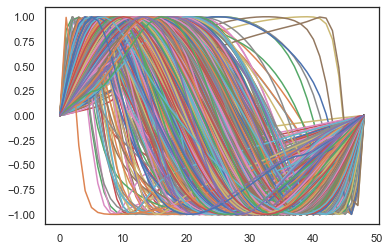

In [41]:
plt.plot(norm_waveform);

# Rate of SO and delta cycles

In [42]:
def get_masked_cycles(IP, cycles):
  mask = np.full(cycles.nsamples, False)
  subset_cycles = cycles.get_metric_dataframe(subset=True)['index']

  for i in subset_cycles:
    inds = cycles.get_inds_of_cycle(i)
    mask[inds] = True

  masked_so_cycles = emd.cycles.get_cycle_vector(IP, mask=mask)
  return masked_so_cycles

In [43]:
def rate_cycle(cycles_vector, duration=1, fs=1000):
  samples_per_segment = duration * fs
  segments = np.array_split(cycles_vector, np.arange(samples_per_segment, len(cycles_vector), samples_per_segment))
  segments = np.array(segments[:-1])

  rate = []
  for segment in segments:
    if -1 in segment:
      rate.append(len(np.unique(segment))-1)
    else:
      rate.append(len(np.unique(segment)))
  rate = np.array(rate)
  rate = rate/duration
  return rate, segments

In [101]:
def check_at_start(cycle_vector, start_point):
    start = start_point
    backward_len = 1
    while cycle_vector[start] != -1:
        backward_len += 1
        start -= 1

    start = start_point
    forward_len = 0
    while cycle_vector[start] != -1:
        forward_len += 1
        start += 1
    return forward_len/(backward_len + forward_len), start

def check_at_end(cycle_vector, start_point):
    start = start_point
    backward_len = 1
    while cycle_vector[start] != -1:
        backward_len += 1
        start -= 1

    start = start_point
    forward_len = 0
    while cycle_vector[start] != -1:
        forward_len += 1
        start += 1
    return backward_len/(backward_len + forward_len), start

def rate_cycle(cycle_vector, duration, fs):
    num_of_segments = len(cycle_vector)//(fs*duration)
    rates = []
    segment = 0

    for i in range(num_of_segments):
        rate = 0
        start = i*fs*duration
        end = (i+1)*fs*duration
        if cycle_vector[start] != -1:
    #         print(f'Partial cycle present at Start: {start}')
            cycle_start_part, start = check_at_start(cycle_vector, start)
            rate += cycle_start_part
        if cycle_vector[end] != -1:
    #         print(f'Partial cycle present at End: {end}')
            cycle_end_part, end = check_at_end(cycle_vector, end)
            rate += cycle_end_part
        segment = cycle_vector[start:end]
        if -1 in segment:
            rate += len(np.unique(segment))-1
        else:
            rate += len(np.unique(segment))
        rates.append(rate)
    return rates

In [47]:
so_cycles_vector = get_masked_cycles(IP, so_cycles)
delta_cycles_vector = get_masked_cycles(IP, delta_cycles)

In [102]:
so_cycles_rates = rate_cycle(so_cycles_vector, duration=10, fs=1000)
delta_cycles_rates = rate_cycle(delta_cycles_vector, duration=10, fs=1000)

In [103]:
# so_cycles_rate, _ = rate_cycle(so_cycles_vector, duration=10)
# delta_cycles_rate, _ = rate_cycle(delta_cycles_vector, duration=10)

In [104]:
np.corrcoef(so_cycles_rates, delta_cycles_rates)

array([[1.        , 0.31881512],
       [0.31881512, 1.        ]])

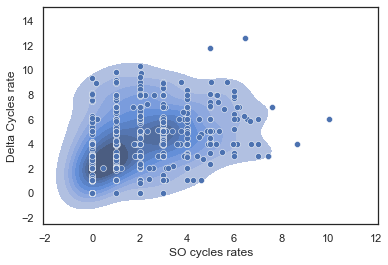

In [105]:
import seaborn as sns

sns.kdeplot(x=so_cycles_rates, y=delta_cycles_rates, fill=True)
ax = sns.scatterplot(x=so_cycles_rates, y=delta_cycles_rates)
ax.set(xlabel='SO cycles rates', ylabel='Delta Cycles rate')
plt.show()

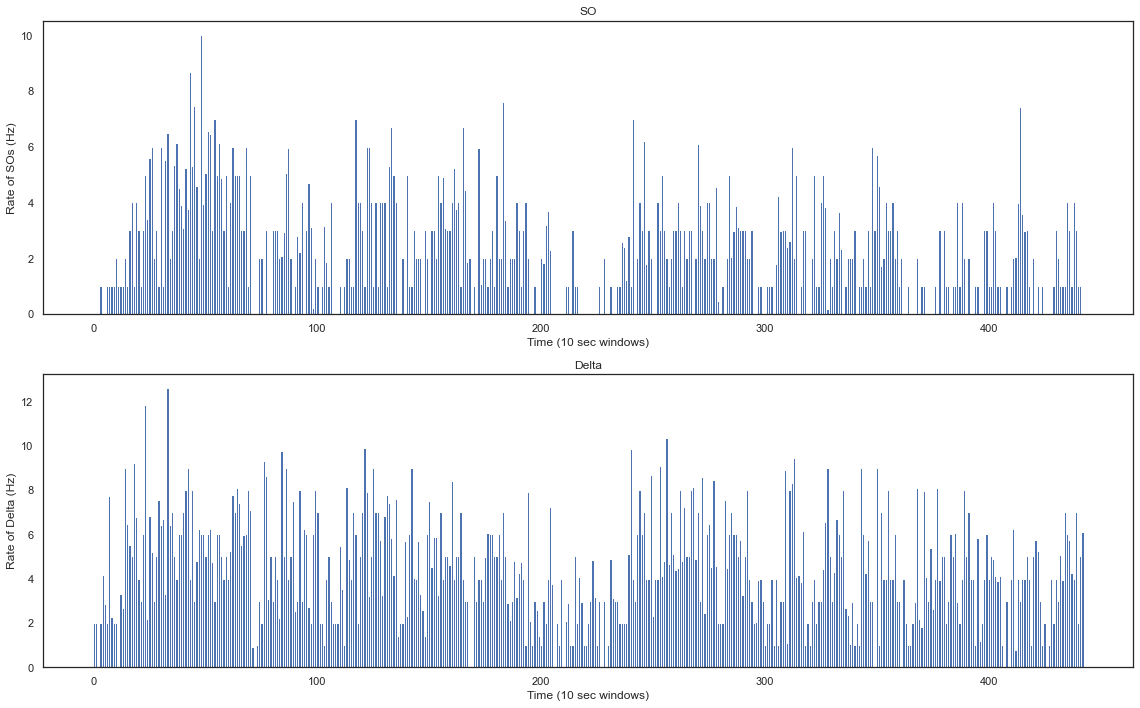

In [106]:
plt.figure(figsize=(16,10))

plt.subplot(2, 1, 1)
plt.title('SO')
plt.bar(range(len(so_cycles_rates)), so_cycles_rates, width=1.0)
plt.ylabel("Rate of SOs (Hz)")
plt.xlabel("Time (10 sec windows)")

plt.subplot(2, 1, 2)
plt.title('Delta')
plt.bar(range(len(delta_cycles_rates)), delta_cycles_rates, width=1.0)
plt.ylabel("Rate of Delta (Hz)")
plt.xlabel("Time (10 sec windows)")

plt.tight_layout()

Text(0.5, 0, 'Number of SOs in 10 sec window')

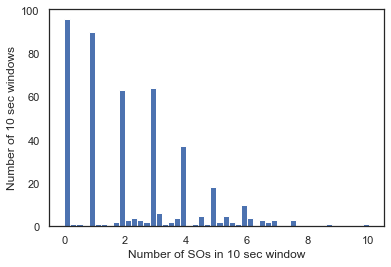

In [100]:
plt.hist(so_cycles_rates, bins=50);
plt.ylabel("Number of 10 sec windows")
plt.xlabel("Number of SOs in 10 sec window")

# PCA on metrics

In [29]:
all_metrics = all_cycles.get_metric_dataframe(subset=True)

In [30]:
pca_df = all_metrics[['duration_samples', 'peak2trough', 'asc2desc', 'max_amp', 'peak_values', 'trough_values', 'mean_if', 'max_if', 'range_if']]

In [31]:
pca_df

,duration_samples,peak2trough,asc2desc,max_amp,peak_values,trough_values,mean_if,max_if,range_if
0,498,0.479568,0.565421,385.419236,268.741512,-385.061739,2.008000,2.288361,0.926787
1,832,0.663332,0.512087,577.478296,335.883058,-464.338443,1.201157,1.832108,1.595199
2,420,0.414319,0.589829,465.991827,308.257680,-372.621361,2.386341,6.268422,4.437658
3,593,0.370283,0.667139,560.010542,481.054485,-372.123774,1.687476,2.618704,1.951302
4,466,0.389308,0.623549,515.758008,495.202314,-392.530321,2.147114,2.919865,1.876605
...,...,...,...,...,...,...,...,...,...
2790,624,0.188361,0.717643,468.194441,193.802866,-409.215842,1.601457,7.891810,7.793397
2791,693,0.487236,0.672330,444.316463,189.675638,-440.601166,1.442929,2.216349,1.463274
2792,783,0.605851,0.726610,487.763041,197.334035,-282.780497,1.277633,2.493442,2.385485
2793,472,0.412788,0.545241,619.922038,390.620448,-619.121028,2.120472,2.662690,1.065864


In [32]:
pca_df = pd.concat([pca_df, pd.DataFrame(all_waveforms.T)], axis=1)

In [33]:
pca_df.columns = pca_df.columns.astype('str')
pca_df

,duration_samples,peak2trough,asc2desc,max_amp,peak_values,trough_values,mean_if,max_if,range_if,0,...,90,91,92,93,94,95,96,97,98,99
0,498,0.479568,0.565421,385.419236,268.741512,-385.061739,2.008000,2.288361,0.926787,6.645168,...,-186.770938,-165.587446,-144.279022,-123.034467,-102.046247,-81.508572,-61.624185,-42.581890,-24.587713,-7.841685
1,832,0.663332,0.512087,577.478296,335.883058,-464.338443,1.201157,1.832108,1.595199,4.988837,...,-149.853062,-130.208832,-111.265123,-93.111385,-75.846506,-59.551324,-44.303763,-30.161466,-17.185819,-5.415892
2,420,0.414319,0.589829,465.991827,308.257680,-372.621361,2.386341,6.268422,4.437658,2.794925,...,-99.843321,-84.972404,-70.988644,-57.962162,-45.965712,-35.043767,-25.238638,-16.575066,-9.067612,-2.735279
3,593,0.370283,0.667139,560.010542,481.054485,-372.123774,1.687476,2.618704,1.951302,7.501764,...,-59.860705,-51.881018,-44.473859,-37.496333,-30.873925,-24.569572,-18.574012,-12.882363,-7.498363,-2.421865
4,466,0.389308,0.623549,515.758008,495.202314,-392.530321,2.147114,2.919865,1.876605,11.884562,...,-156.569800,-143.746271,-131.032732,-117.830692,-103.663555,-88.214040,-71.304315,-52.853819,-32.845241,-11.315143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2790,624,0.188361,0.717643,468.194441,193.802866,-409.215842,1.601457,7.891810,7.793397,4.244968,...,-196.484421,-177.030815,-156.571094,-135.382784,-113.746567,-91.951709,-70.291730,-49.066908,-28.592611,-9.190587
2791,693,0.487236,0.672330,444.316463,189.675638,-440.601166,1.442929,2.216349,1.463274,3.699081,...,-233.054878,-209.094352,-185.064538,-161.140757,-137.359067,-113.589173,-89.564633,-64.989204,-39.639502,-13.426407
2792,783,0.605851,0.726610,487.763041,197.334035,-282.780497,1.277633,2.493442,2.385485,5.046701,...,-189.644231,-176.895295,-163.149198,-148.115036,-131.462266,-112.870335,-92.078971,-68.897438,-43.227992,-15.031248
2793,472,0.412788,0.545241,619.922038,390.620448,-619.121028,2.120472,2.662690,1.065864,8.186356,...,-330.204760,-296.295907,-261.588114,-226.314864,-190.716525,-155.037820,-119.524785,-84.421245,-49.964892,-16.391834


In [41]:


pca = PCA(n_components=5)
pca.fit(pca_df)
X = pd.DataFrame(pca.transform(pca_df))
X.columns = [f'PC-{i}' for i in range(1,6)]

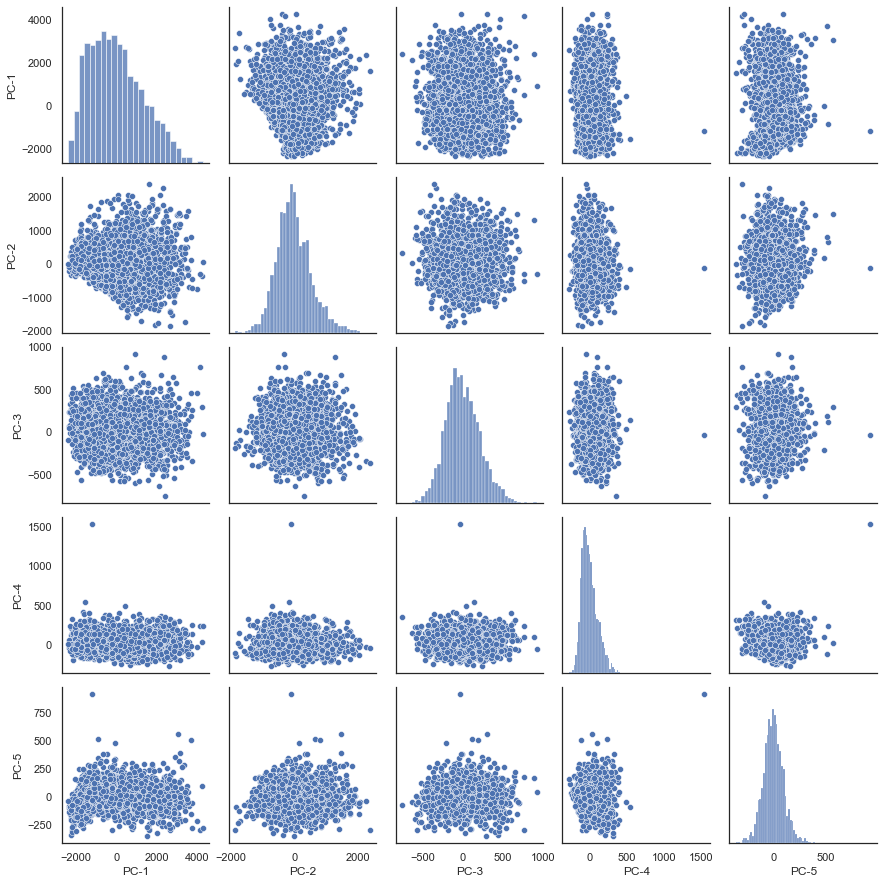

In [45]:
sns.pairplot(X)

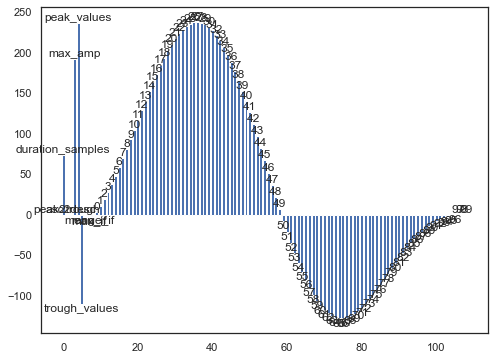

In [46]:
plt.figure(figsize=(8, 6))

component = 1
pca_weights = (pca.components_.T * np.sqrt(pca.explained_variance_))[:, component-1]
p = plt.bar(range(len(pca_weights)), pca_weights)
plt.bar_label(p, list(pca_df.columns));

# PCA on all 5 Post-Trials

In [47]:
path_to_data = './data_13_CN/'
data_file = 'Cleaned_Trial1_PFC_100_CH63_0.continuous.mat'
states_file = '2019-05-13_11-24-48_post_trial1-states.mat'
pfc_data1, sleep_scoring1 = load_mat_data(path_to_data, data_file, states_file)

data_file = 'Cleaned_Trial2_PFC_100_CH63_0.continuous.mat'
states_file = '2019-05-13_12-15-25_post_trial2-states.mat'
pfc_data2, sleep_scoring2 = load_mat_data(path_to_data, data_file, states_file)

data_file = 'Cleaned_Trial3_PFC_100_CH63_0.continuous.mat'
states_file = '2019-05-13_13-05-57_post_trial3-states.mat'
pfc_data3, sleep_scoring3 = load_mat_data(path_to_data, data_file, states_file)

data_file = 'Cleaned_Trial4_PFC_100_CH63_0.continuous.mat'
states_file = '2019-05-13_13-56-29_post_trial4-states.mat'
pfc_data4, sleep_scoring4 = load_mat_data(path_to_data, data_file, states_file)

data_file = 'Cleaned_Trial5_PFC_100_CH63_0.continuous.mat'
states_file = '2019-05-13_14-53-54_post_trial5-states.mat'
pfc_data5, sleep_scoring5 = load_mat_data(path_to_data, data_file, states_file)

nrem_epochs1 = np.array(get_all_NREM_epochs(sleep_scoring1))
nrem_epochs2 = np.array(get_all_NREM_epochs(sleep_scoring2))
nrem_epochs3 = np.array(get_all_NREM_epochs(sleep_scoring3))
nrem_epochs4 = np.array(get_all_NREM_epochs(sleep_scoring4))
nrem_epochs5 = np.array(get_all_NREM_epochs(sleep_scoring5))

In [48]:
len(pfc_data1)/len(sleep_scoring1)

2500.155844155844

In [49]:
fs = 2500
nrem_filtered_data1, nrem_data1 = get_nrem_filtered(pfc_data1, nrem_epochs1, fs=2500)
nrem_filtered_data2, nrem_data2 = get_nrem_filtered(pfc_data2, nrem_epochs2, fs=2500)
nrem_filtered_data3, nrem_data3 = get_nrem_filtered(pfc_data3, nrem_epochs3, fs=2500)
nrem_filtered_data4, nrem_data4 = get_nrem_filtered(pfc_data4, nrem_epochs4, fs=2500)
nrem_filtered_data5, nrem_data5 = get_nrem_filtered(pfc_data5, nrem_epochs5, fs=2500)

C:\Users\nikhi\AppData\Roaming\Python\Python39\site-packages\neurodsp\filt\utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))


In [50]:
# Extract Instantaneous phase (IP), frequency and amplitude (from Hilbert Transform)
IP1, IF1, IA1 = emd.spectra.frequency_transform(nrem_filtered_data1, fs, 'hilbert')
IP2, IF2, IA2 = emd.spectra.frequency_transform(nrem_filtered_data2, fs, 'hilbert')
IP3, IF3, IA3 = emd.spectra.frequency_transform(nrem_filtered_data3, fs, 'hilbert')
IP4, IF4, IA4 = emd.spectra.frequency_transform(nrem_filtered_data4, fs, 'hilbert')
IP5, IF5, IA5 = emd.spectra.frequency_transform(nrem_filtered_data5, fs, 'hilbert')

# Get cycles using IP
C1 = emd.cycles.Cycles(IP1)
C2 = emd.cycles.Cycles(IP2)
C3 = emd.cycles.Cycles(IP3)
C4 = emd.cycles.Cycles(IP4)
C5 = emd.cycles.Cycles(IP5)

 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking Cycles inputs - trimming singleton from input 'IP'


In [51]:
cycles1 = get_cycles_with_metrics(C1, nrem_filtered_data1, IA1, IF1)
cycles2 = get_cycles_with_metrics(C2, nrem_filtered_data2, IA2, IF2)
cycles3 = get_cycles_with_metrics(C3, nrem_filtered_data3, IA3, IF3)
cycles4 = get_cycles_with_metrics(C4, nrem_filtered_data4, IA4, IF4)
cycles5 = get_cycles_with_metrics(C5, nrem_filtered_data5, IA5, IF5)

In [52]:
metrics1 = cycles1.get_metric_dataframe()
metrics2 = cycles2.get_metric_dataframe()
metrics3 = cycles3.get_metric_dataframe()
metrics4 = cycles4.get_metric_dataframe()
metrics5 = cycles5.get_metric_dataframe()
# amp_thresh = np.percentile(IA, 25) # 25th percentile of the amplitude
peak_thresh1 = np.percentile(metrics1['peak_values'], 85)
trough_thresh1 = np.percentile(metrics1['trough_values'], 40)
peak_thresh2 = np.percentile(metrics2['peak_values'], 85)
trough_thresh2 = np.percentile(metrics2['trough_values'], 40)
peak_thresh3 = np.percentile(metrics3['peak_values'], 85)
trough_thresh3 = np.percentile(metrics3['trough_values'], 40)
peak_thresh4 = np.percentile(metrics4['peak_values'], 85)
trough_thresh4 = np.percentile(metrics4['trough_values'], 40)
peak_thresh5 = np.percentile(metrics5['peak_values'], 85)
trough_thresh5 = np.percentile(metrics5['trough_values'], 40)

lo_freq_duration = fs/0.1
hi_freq_duration = fs/4

In [53]:
conditions1 = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              # f'peak_values>={peak_thresh}',
              f'trough_values<={trough_thresh1}']
conditions2 = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              # f'peak_values>={peak_thresh}',
              f'trough_values<={trough_thresh2}']
conditions3 = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              # f'peak_values>={peak_thresh}',
              f'trough_values<={trough_thresh3}']
conditions4 = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              # f'peak_values>={peak_thresh}',
              f'trough_values<={trough_thresh4}']
conditions5 = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              # f'peak_values>={peak_thresh}',
              f'trough_values<={trough_thresh5}']

all_cycles1 = get_cycles_with_conditions(cycles1, conditions1)
all_cycles2 = get_cycles_with_conditions(cycles2, conditions2)
all_cycles3 = get_cycles_with_conditions(cycles3, conditions3)
all_cycles4 = get_cycles_with_conditions(cycles4, conditions4)
all_cycles5 = get_cycles_with_conditions(cycles5, conditions5)

In [54]:
all_waveforms1, _ = emd.cycles.phase_align(IP1, nrem_filtered_data1,
                                                            cycles=all_cycles1.iterate(through='subset'), npoints=100)
all_waveforms2, _ = emd.cycles.phase_align(IP2, nrem_filtered_data2,
                                                            cycles=all_cycles2.iterate(through='subset'), npoints=100)
all_waveforms3, _ = emd.cycles.phase_align(IP3, nrem_filtered_data3,
                                                            cycles=all_cycles3.iterate(through='subset'), npoints=100)
all_waveforms4, _ = emd.cycles.phase_align(IP4, nrem_filtered_data4,
                                                            cycles=all_cycles4.iterate(through='subset'), npoints=100)
all_waveforms5, _ = emd.cycles.phase_align(IP5, nrem_filtered_data5,
                                                            cycles=all_cycles5.iterate(through='subset'), npoints=100)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'


In [55]:
all_metrics1 = all_cycles1.get_metric_dataframe(subset=True)
all_metrics2 = all_cycles2.get_metric_dataframe(subset=True)
all_metrics3 = all_cycles3.get_metric_dataframe(subset=True)
all_metrics4 = all_cycles4.get_metric_dataframe(subset=True)
all_metrics5 = all_cycles5.get_metric_dataframe(subset=True)

In [56]:
pca_df1 = all_metrics1[['duration_samples', 'peak2trough', 'asc2desc', 'max_amp', 'peak_values', 'trough_values', 'mean_if', 'max_if', 'range_if']]
pca_df1 = pd.concat([pca_df1, pd.DataFrame(all_waveforms1.T)], axis=1)

pca_df2 = all_metrics2[['duration_samples', 'peak2trough', 'asc2desc', 'max_amp', 'peak_values', 'trough_values', 'mean_if', 'max_if', 'range_if']]
pca_df2 = pd.concat([pca_df2, pd.DataFrame(all_waveforms2.T)], axis=1)

pca_df3 = all_metrics3[['duration_samples', 'peak2trough', 'asc2desc', 'max_amp', 'peak_values', 'trough_values', 'mean_if', 'max_if', 'range_if']]
pca_df3 = pd.concat([pca_df3, pd.DataFrame(all_waveforms3.T)], axis=1)

pca_df4 = all_metrics4[['duration_samples', 'peak2trough', 'asc2desc', 'max_amp', 'peak_values', 'trough_values', 'mean_if', 'max_if', 'range_if']]
pca_df4 = pd.concat([pca_df4, pd.DataFrame(all_waveforms4.T)], axis=1)

pca_df5 = all_metrics5[['duration_samples', 'peak2trough', 'asc2desc', 'max_amp', 'peak_values', 'trough_values', 'mean_if', 'max_if', 'range_if']]
pca_df5 = pd.concat([pca_df5, pd.DataFrame(all_waveforms5.T)], axis=1)

In [57]:
pca_df_combined = pd.concat([pca_df1, pca_df2, pca_df3, pca_df4, pca_df5])
pca_df_combined.columns = pca_df_combined.columns.astype('str')

In [58]:
pca_df_combined

,duration_samples,peak2trough,asc2desc,max_amp,peak_values,trough_values,mean_if,max_if,range_if,0,...,90,91,92,93,94,95,96,97,98,99
0,866,0.374093,0.555473,213.111977,121.632195,-193.448410,2.885489,5.768119,4.584288,6.651013,...,-112.519455,-100.276311,-87.713465,-74.989333,-62.264064,-49.705813,-37.487838,-25.785398,-14.780495,-4.662556
1,1096,0.329381,0.565664,212.029051,127.822182,-211.898903,2.279391,5.174361,4.056746,2.717674,...,-109.421128,-98.003122,-86.364747,-74.582778,-62.732776,-50.894544,-39.149121,-27.579748,-16.272612,-5.317071
2,957,0.567401,0.556370,435.811031,427.750109,-211.826149,2.611521,11.132593,8.955283,8.957028,...,-28.685149,-24.027258,-19.874726,-16.179598,-12.888793,-9.952256,-7.324343,-4.964434,-2.830986,-0.903731
3,1046,0.188362,0.587078,168.190806,38.244393,-166.073105,2.389663,17.756701,16.668780,0.856532,...,-75.059504,-66.489933,-57.931648,-49.446122,-41.095488,-32.937559,-25.028346,-17.419490,-10.157289,-3.281975
4,866,0.544866,0.543966,291.128495,283.477176,-174.335294,2.886556,4.427635,1.797564,5.941422,...,-57.859693,-50.964340,-44.226827,-37.663298,-31.288616,-25.114517,-19.149534,-13.400361,-7.872499,-2.568579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2137,1386,0.433756,0.562624,223.285235,220.825166,-195.463112,1.802818,2.156510,1.233461,5.059791,...,-87.812902,-77.816074,-67.805215,-57.850975,-48.029647,-38.417623,-29.094012,-20.142077,-11.651190,-3.720181
2138,1082,0.655765,0.572216,616.181864,613.071952,-263.044418,2.308145,5.880278,5.052282,11.014615,...,-78.288540,-69.532664,-60.914238,-52.429066,-44.071393,-35.833648,-27.705910,-19.680598,-11.747531,-3.897195
2139,1052,0.448817,0.565301,424.377906,265.729892,-423.408612,2.378094,2.810883,1.165190,4.541951,...,-222.236767,-198.721628,-174.769874,-150.566217,-126.297053,-102.150947,-78.316373,-54.979371,-32.323692,-10.524994
2140,1348,0.572967,0.627578,417.739187,301.925568,-383.157619,1.854933,2.227678,0.984586,4.095950,...,-154.776949,-135.882066,-117.268777,-99.078352,-81.447572,-64.507718,-48.383637,-33.192911,-19.045161,-6.042412


In [89]:
pca_df_combined = pca_df_combined[['duration_samples', 'peak2trough', 'asc2desc', 'max_amp', 'peak_values', 'trough_values', 'mean_if', 'max_if', 'range_if']]

In [90]:
pca = PCA(n_components=5)
pca.fit(pca_df)
X = pd.DataFrame(pca.transform(pca_df))
X.columns = [f'PC-{i}' for i in range(1,6)]

pca_combined = PCA(n_components=5)
pca_combined.fit(pca_df_combined)
X_combined = pd.DataFrame(pca_combined.transform(pca_df_combined))
X_combined.columns = [f'PC-{i}' for i in range(1,6)]

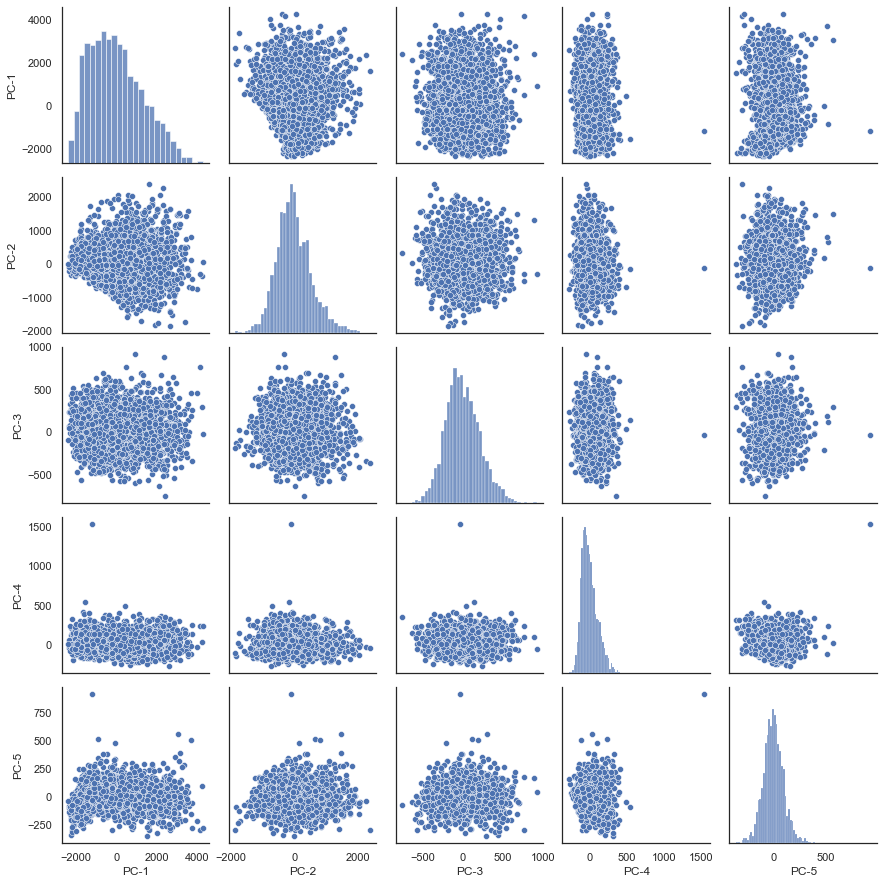

In [91]:
sns.pairplot(X)

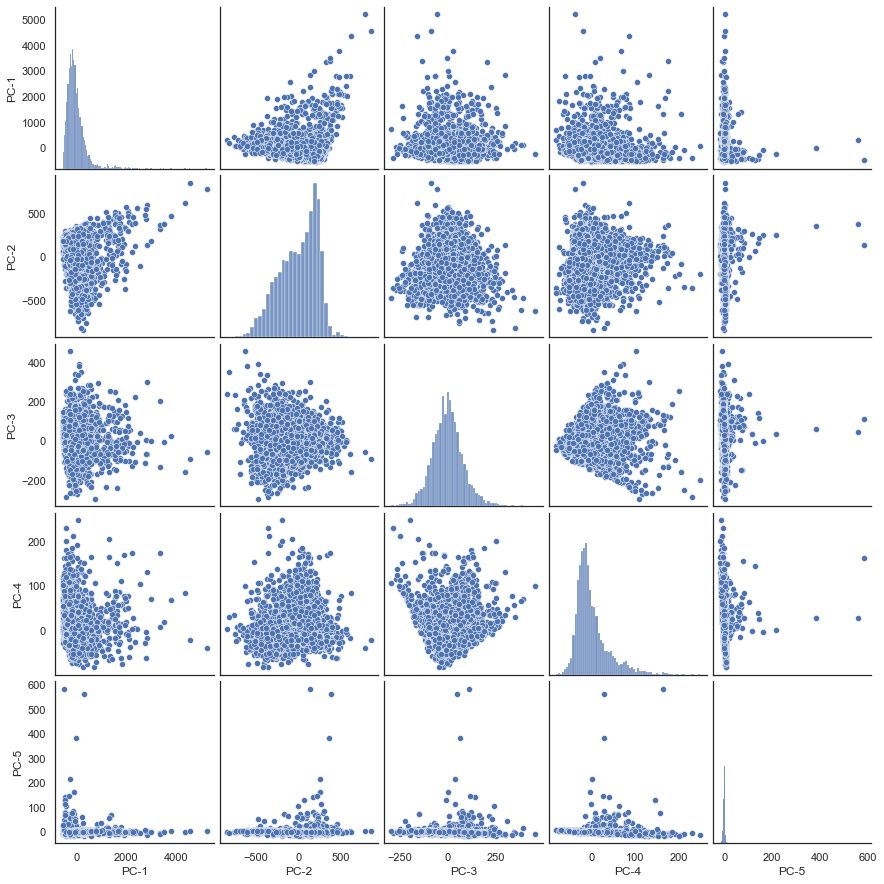

In [92]:
sns.pairplot(X_combined)

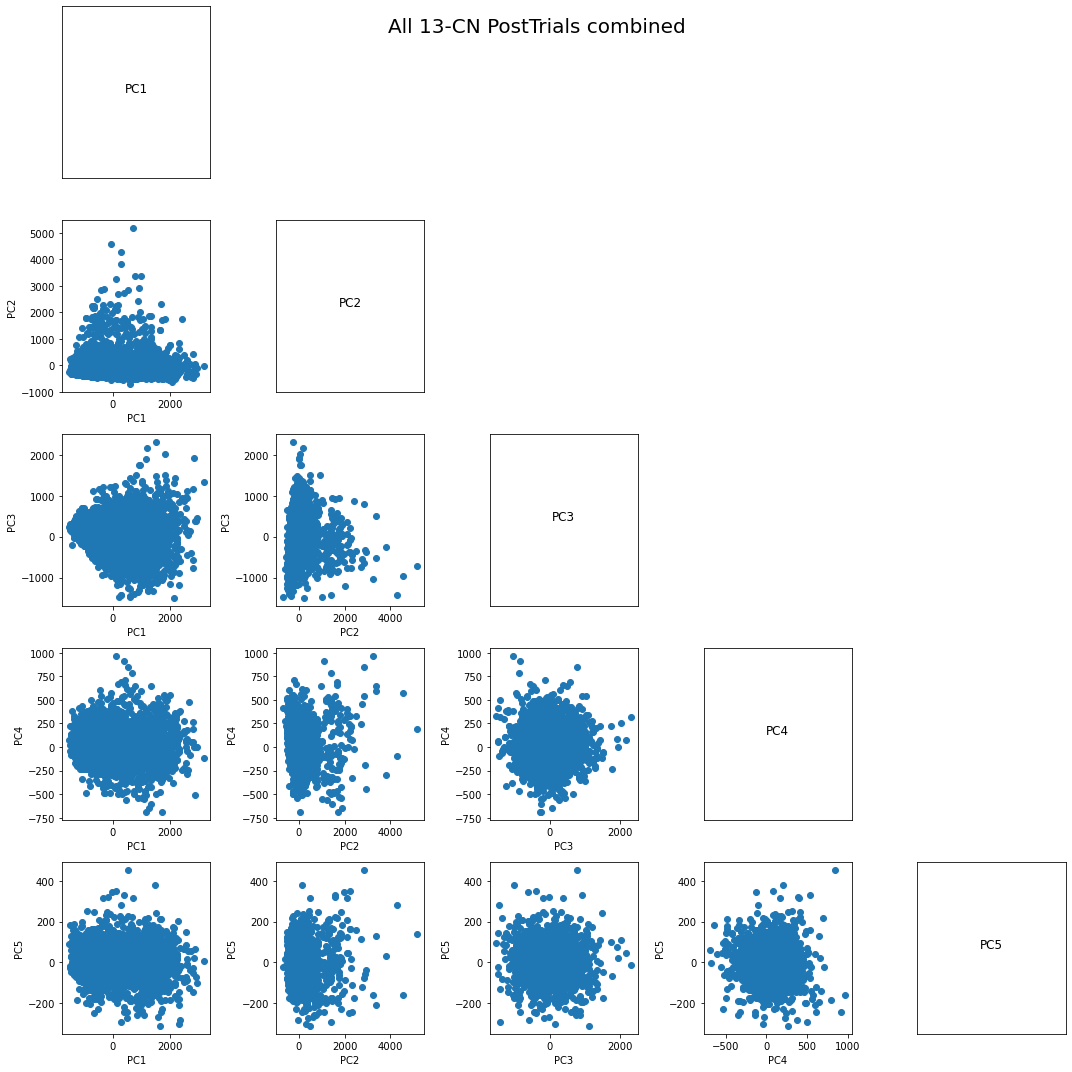

In [82]:
n_components = 5

# Create a figure with a 5x5 grid of subplots
fig, axes = plt.subplots(n_components, n_components, figsize=(15, 15), facecolor="white")

# Loop to create scatter plots
for i in range(n_components):
    for j in range(n_components):
        if i == j:
            axes[i, j].text(0.5, 0.5, f'PC{i+1}', fontsize=12, ha='center')
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
        elif i > j:
            axes[i, j].scatter(X_combined[:, j], X_combined[:, i])
            axes[i, j].set_xlabel(f'PC{j+1}')
            axes[i, j].set_ylabel(f'PC{i+1}')
        else:
            axes[i, j].axis('off')

# Adjust layout
plt.tight_layout()
fig.suptitle("All 13-CN PostTrials combined", fontsize=20)
plt.show()

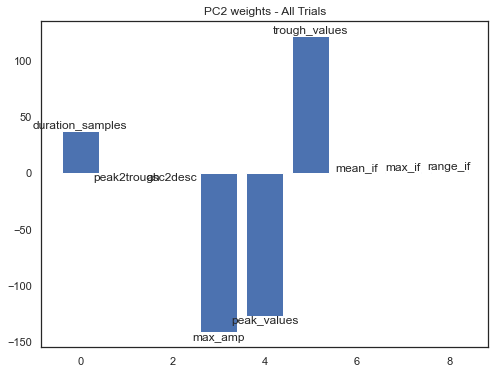

In [93]:
plt.figure(figsize=(8, 6), facecolor="white")

component = 2
pca_weights = (pca_combined.components_.T * np.sqrt(pca_combined.explained_variance_))[:, component-1]
pca_weights = pca_weights
p = plt.bar(range(len(pca_weights)), pca_weights)
plt.bar_label(p, list(pca_df_combined.columns));
plt.title(f"PC{component} weights - All Trials");

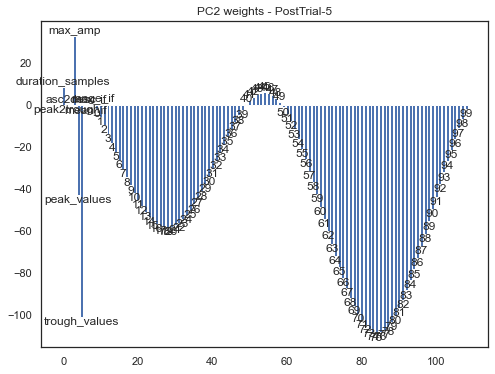

In [65]:
plt.figure(figsize=(8, 6), facecolor="white")

component = 2
pca_weights = (pca.components_.T * np.sqrt(pca.explained_variance_))[:, component-1]
p = plt.bar(range(len(pca_weights)), pca_weights)
plt.bar_label(p, list(pca_df.columns));
plt.title(f"PC{component} weights - PostTrial-5");

In [131]:
scaled_pca_df_combined = StandardScaler().fit_transform(pca_df)

In [132]:
import umap.umap_ as umap

In [155]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, metric="mahalanobis")

In [156]:
embedding = reducer.fit_transform(scaled_pca_df_combined)

In [157]:
fig = px.scatter_3d(x=embedding[:, 0], y=embedding[:, 1], z=embedding[:, 2])
fig.show()

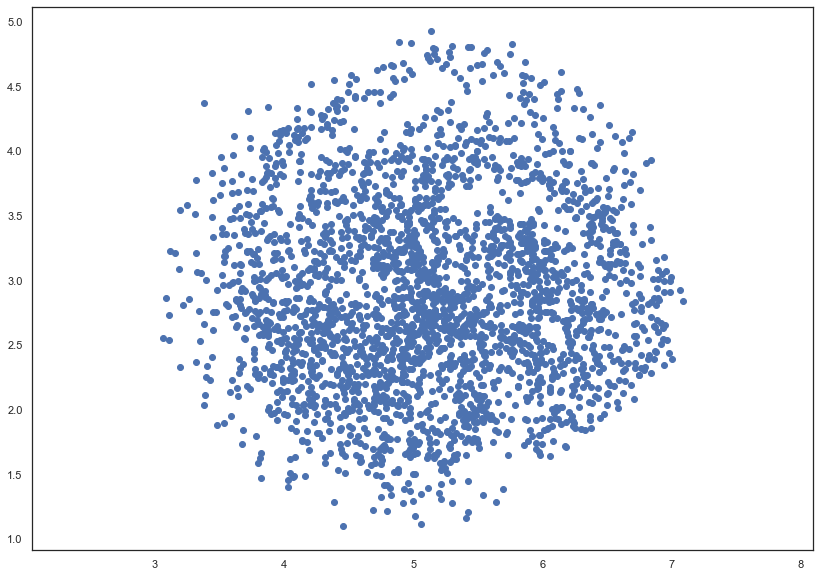

In [158]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')